In [80]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [81]:
# 设置GPU设备
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [82]:
# 一些可视化的函数
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [83]:
# 加载模型
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

图像数组的维度为: (1024, 1224, 3)


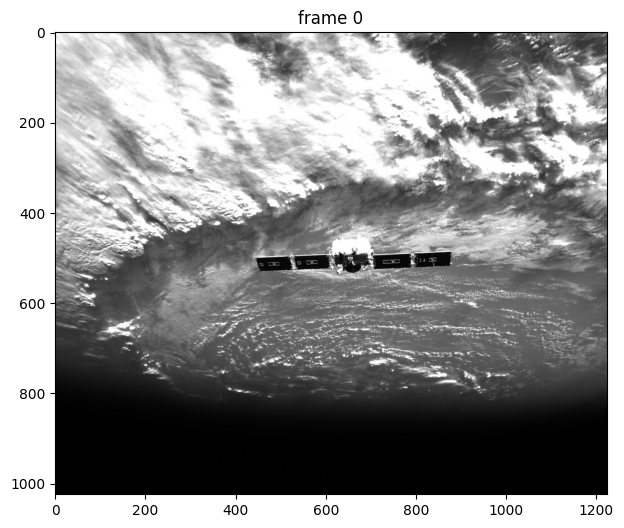

In [84]:
# 加载数据
video_dir = "./videos/davinci_raofei_3jpg_part"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# cv2可视化第一帧图像
frame_idx = 0
image = cv2.imread(os.path.join(video_dir, frame_names[frame_idx]))
print("图像数组的维度为:", image.shape)
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

frame loading (JPEG): 100%|██████████| 71/71 [00:00<00:00, 75.23it/s]


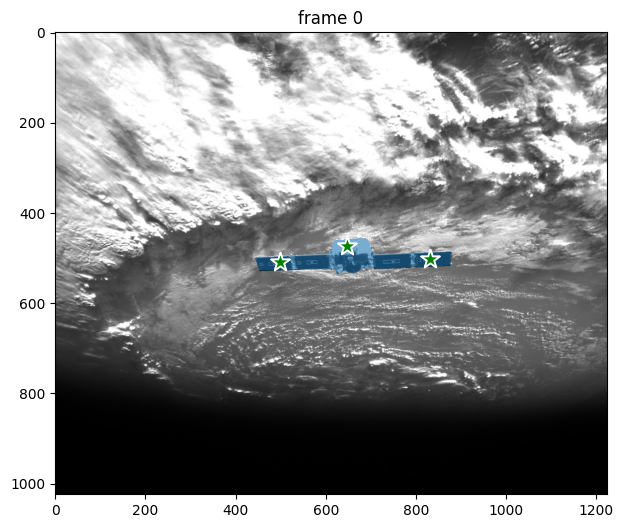

In [85]:
# 初始化推理
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

# 标注第一帧
ann_frame_idx = 0  # the frame index we interact with
 # give a unique id to each object we interact with (it can be any integers)
"""
0 主体
1 左帆板
2 右帆板
"""
prompts = {}  # hold all the clicks we add for visualization

# 整体正点
ann_obj_id = 0 
points = np.array([[499, 509], [648, 474], [832, 502]], dtype=np.float32)
labels = np.array([1, 1, 1], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

"""
# 主体正负点
ann_obj_id = 0 
points = np.array([[440, 620], [380, 630], [480, 610]], dtype=np.float32)
labels = np.array([1, 0, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# 左帆板正负点
ann_obj_id = 1 
points = np.array([[380, 630], [440, 620]], dtype=np.float32)
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# 右帆板正负点
ann_obj_id = 2 
points = np.array([[480, 610], [440, 620]], dtype=np.float32)
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels

# `add_new_points_or_box` returns masks for all objects added so far on this interacted frame
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)
"""

# cv2可视化第一帧图像和标注
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
image = cv2.imread(os.path.join(video_dir, frame_names[ann_frame_idx]))
plt.imshow(image)
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [86]:
# 在整个视频帧进行推理
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████| 71/71 [00:02<00:00, 26.75it/s]


In [87]:
# 保存mask结果
def save_white_mask(mask, filename):
    # 获取掩膜的高度和宽度
    h, w = mask.shape[-2:]

    # 创建一个单通道的掩膜图像，值为0或255
    white_mask = np.zeros((h, w), dtype=np.uint8)  # 初始化为全黑
    # 如果mask是3维，取最后一个维度的最大值
    if mask.ndim == 3:
        mask = np.max(mask, axis=0)  # 合并到2维
    white_mask[mask > 0] = 255  # 将掩膜区域设置为白色

    # 保存为单通道图像
    cv2.imwrite(filename, white_mask)

# 保存mask路径
save_dir = "./results"

for out_frame_idx in range(0, len(frame_names), 1):
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # 可视化并保存图像
        print(frame_names[out_frame_idx])
        save_white_mask(out_mask, os.path.join(save_dir, frame_names[out_frame_idx]))

00130.jpg
00131.jpg
00132.jpg
00133.jpg
00134.jpg
00135.jpg
00136.jpg
00137.jpg
00138.jpg
00139.jpg
00140.jpg
00141.jpg
00142.jpg
00143.jpg
00144.jpg
00145.jpg
00146.jpg
00147.jpg
00148.jpg
00149.jpg
00150.jpg
00151.jpg
00152.jpg
00153.jpg
00154.jpg
00155.jpg
00156.jpg
00157.jpg
00158.jpg
00159.jpg
00160.jpg
00161.jpg
00162.jpg
00163.jpg
00164.jpg
00165.jpg
00166.jpg
00167.jpg
00168.jpg
00169.jpg
00170.jpg
00171.jpg
00172.jpg
00173.jpg
00174.jpg
00175.jpg
00176.jpg
00177.jpg
00178.jpg
00179.jpg
00180.jpg
00181.jpg
00182.jpg
00183.jpg
00184.jpg
00185.jpg
00186.jpg
00187.jpg
00188.jpg
00189.jpg
00190.jpg
00191.jpg
00192.jpg
00193.jpg
00194.jpg
00195.jpg
00196.jpg
00197.jpg
00198.jpg
00199.jpg
00200.jpg


In [88]:
# 可视化结果
"""
vis_frame_stride = 50
plt.close("all")
for out_frame_idx in range(0, len(frame_names), 1):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        # 可视化并保存图像
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        # 本地保存图像
        save_dir = "./results"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, frame_names[out_frame_idx])
        plt.savefig(save_path, dpi=300)
"""

'\nvis_frame_stride = 50\nplt.close("all")\nfor out_frame_idx in range(0, len(frame_names), 1):\n    plt.figure(figsize=(6, 4))\n    plt.title(f"frame {out_frame_idx}")\n    plt.imshow(cv2.imread(os.path.join(video_dir, frame_names[out_frame_idx])))\n    for out_obj_id, out_mask in video_segments[out_frame_idx].items():\n        # 可视化并保存图像\n        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)\n        # 本地保存图像\n        save_dir = "./results"\n        if not os.path.exists(save_dir):\n            os.makedirs(save_dir)\n        save_path = os.path.join(save_dir, frame_names[out_frame_idx])\n        plt.savefig(save_path, dpi=300)\n'